# Long-term movement monitoring database
## Here is how I work with this data

Using the Waveform Data Base (wfdb) library, I load and work with the Physionet Long-term Movement Monitoring (LTMM) data as follows.

In [5]:
import wfdb
import os

First lets load the database.

In [6]:
dbs_dir = os.path.abspath("../../data/physionet/ltmm/")
dbs = wfdb.io.get_record_list('ltmm')

Now I will go ahead and load a record as an example.

In [3]:
t_min = 60
fps = 200
t_frame = t_min * 60 * fps
dbs_path = os.path.abspath("../../data/physionet/ltmm/%s" % dbs[0])
rec = wfdb.io.rdrecord(dbs_path, sampfrom=0, sampto=t_frame)
rec, rec.sig_name

(<wfdb.io.record.Record at 0x7f0addf63940>,
 ['v-acceleration',
  'ml-acceleration',
  'ap-acceleration',
  '/s 0 0 -1124 3453 0 yaw-velocity',
  '/s 0 0 -883 -9724 0 pitch-velocity',
  '/s 0 0 634 -26911 0 roll-velocity'])

In [4]:
signal = rec.p_signal
print(signal.shape)

(720000, 6)


And just to give a quick sense of what this looks like.

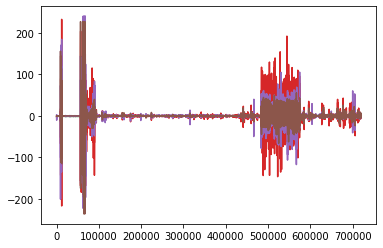

In [5]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.plot(signal[:,i])
plt.show()

Now some functions that will be useful for deploying my model.

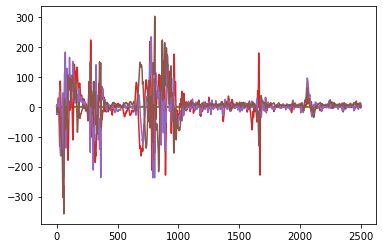

In [6]:
def minutes2frames(t_minutes, fps=100):
    return t_minutes*fps*60

def grab_window(dbs, irec = 0, fstart = 0, fclose = 2500):
    dbs_path = os.path.abspath("../../data/physionet/ltmm/%s" % dbs[irec])
    rec = wfdb.io.rdrecord( dbs_path, 
                            sampfrom=fstart, 
                            sampto=fclose )
    return rec.p_signal, rec.sig_name

def plot_window(dbs, irec = 0, fstart = 0, fclose = 2500,
               acc = True, rot = True):
    clip, head = grab_window(dbs, irec = irec, 
                             fstart = fstart, fclose = fclose )
    c1 = "blue"
    c2 = "green"
    if acc and rot:
        fig, ax1 = plt.subplots()
        c1 = "blue"
        ax1.set_xlabel('time (frames)')
        ax1.set_ylabel('accelerations', color = c1)
        for i in range(3):
            ax1.plot(clip[:,i], label=head[i], color = c1)
        
        ax2 = ax1.twinx()
        ax2.set_ylabel("rotations", color = c2)
        for i in range(3):
            ax2.plot(clip[:,i+3], label=head[i+3], color = c2)

        fig.tight_layout()
    if acc and not rot:
        plt.xlabel('time (frames)')
        plt.ylabel('accelerations', color = c1)
        for i in range(3):
            plt.plot(clip[:,i], label=head[i], color = c1)
            
    if rot and not acc:
        plt.xlabel('time (frames)')
        plt.ylabel('rotations', color = c2)
        for i in range(3):
            plt.plot(clip[:,i+3], label=head[i+3], color = c2)
    
    plt.show()
    plt.clf()

clip, head = grab_window(dbs, irec = 13)
clip.shape
plt.plot(clip)

So now we can get a sense of what a sample frame looks like. Here's another example of what I can do with the `plot_window()` function.

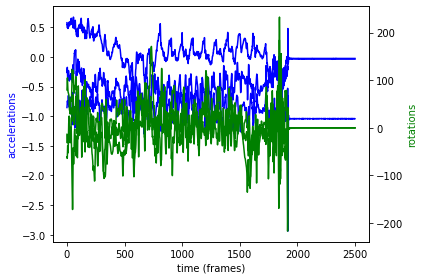

<Figure size 432x288 with 0 Axes>

In [7]:
fstart = 10000
ftotal = 2500
fclose = fstart + ftotal
plot_window(dbs, fstart = fstart, fclose = fclose )

And just a couple more functions to save and load a model.

In [8]:
from tensorflow.keras.models import model_from_json
import h5py
import os
# serialize model to JSON
def save_model(model):
    loc = os.path.abspath("../../models")
    fjson = "%s/%s.json" % (loc, fstr)
    fh5   = "%s/%s.h5" % (loc, fstr)
    model_json = model.to_json()
    with open(fjson, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(fh5)
    print("Saved model to disk")
    
def load_model(fstr = "model"):
    loc = os.path.abspath("../../models")
    fjson = "%s/%s.json" % (loc, fstr)
    fh5   = "%s/%s.h5" % (loc, fstr)
    json_file = open(fjson, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(fh5)
    print("Loaded model from disk")
    return loaded_model

model = load_model(fstr = "model_hybrid_20")

Loaded model from disk


In [9]:
df, header = grab_window(dbs, irec = 0, fstart = 0, fclose = 256)

In [10]:
df.shape

(256, 6)

(256, 6) (512, 6)
(256,) (512,)


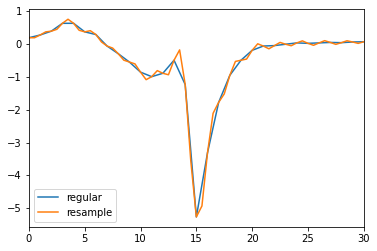

array([[-0.02430932, -0.00709566, -1.05035309,  0.19197293,  2.66644846,
         0.00706453],
       [-0.02239338, -0.00691597, -1.05367   ,  0.19138965,  2.05714311,
        -0.00439768],
       [-0.0214494 , -0.00709566, -1.05905317,  0.27424704,  0.83943748,
        -0.01412905],
       ...,
       [-0.02380142, -0.01067618, -1.0395495 ,  0.01346675, -0.86462658,
         0.0144137 ],
       [-0.02430932, -0.00993393, -1.04165302,  0.06170558, -0.2045688 ,
         0.02119358],
       [-0.0250431 , -0.00818669, -1.04657842,  0.16741755,  1.59773113,
         0.01730309]])

In [11]:
from scipy import signal
import numpy as np
x = np.arange(0,len(df),1)
df2 = signal.resample(df,2*len(df))
print(df.shape, df2.shape)
x2 = np.arange(0,len(df),0.5)
print(x.shape, x2.shape)
plt.plot(x, df[:,3], label="regular")
plt.plot(x2, df2[:,3], label="resample")
plt.xlim([0,30])
plt.legend()
plt.show()
df2

In [13]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def grab_windows(dbs, irec = 0, start = 0, end = 60, 
                 fps = 100, stride = 200):
    resample = fps / 200
    windows = []
    n_frames = (end - start)*fps
    n_strides = int(n_frames / stride)
    
    for i in range(n_strides):
        _fs = start + i*stride
        _fc = _fs + int(256*resample)
        _df, _head = grab_window(dbs, irec = irec, fstart = _fs, fclose = _fc)
        if resample != 1:
            _df = signal.resample(_df,256)
        windows.append(_df)
    return np.array(windows)
    
def evaluate_windows(dbs, irec = 0, start = 0, end = 60, fps = 100, stride = 256):
    _windows = grab_windows(dbs, irec = irec, 
                            start = start, end = end, 
                            fps = fps, stride = stride)
    results = model.predict(_windows)
#     results[:,0] = results[:,0] * 4
#     return np.argmax(results, axis=1)
    return results

def grab_hours(dbs, irec = 0, hour_start = 0, hour_end = 24, verbose = False):
    results = []
    for i in range(hour_start, hour_end):
        t_start = i * 60*60
        t_end = (i+1) * 60*60
        if verbose:
            print("Hour ", i+1)
        results.extend(evaluate_windows(dbs, irec = irec, 
                                        start = t_start, end = t_end))
    return np.array(results)

## Now, let's use these to do some fall classification!

In [17]:
result = grab_hours(dbs, hour_start = 0, hour_end=24, irec=51)

In [157]:
# result = np.array(result)
result = np.array(result)

## Now here is a tunable parameter 
This helps better identify how sensitive I am in my interpretation of the model classification of a stumble event. I am requiring $P(\text{stumble}) > 0.85$.

In [18]:
print(result)
t_factor = len(result) / 24
t = np.arange(0,len(result),1) / t_factor
resultt = np.column_stack((t, result))

[[0.4043352  0.33457744 0.26108742]
 [0.3733926  0.3463763  0.28023103]
 [0.25955442 0.4058753  0.33457032]
 ...
 [0.5923959  0.21729475 0.19030939]
 [0.5213153  0.26656356 0.21212113]
 [0.6080002  0.20682472 0.18517508]]


In [19]:
print(resultt)

[[0.00000000e+00 4.04335201e-01 3.34577441e-01 2.61087418e-01]
 [7.11237553e-04 3.73392612e-01 3.46376300e-01 2.80231029e-01]
 [1.42247511e-03 2.59554416e-01 4.05875295e-01 3.34570318e-01]
 ...
 [2.39978663e+01 5.92395902e-01 2.17294753e-01 1.90309390e-01]
 [2.39985775e+01 5.21315277e-01 2.66563565e-01 2.12121129e-01]
 [2.39992888e+01 6.08000219e-01 2.06824720e-01 1.85175076e-01]]


Text(0.5, 0, 'time (hour)')

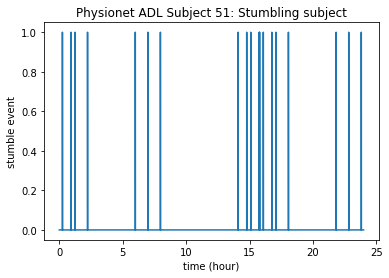

In [178]:
t = np.arange(0,len(result),1) / t_factor
plt.plot(resultt[:,0],(resultt[:,2]>0.8))
plt.title("Physionet ADL Subject 51: Stumbling subject")
plt.ylabel("stumble event")
plt.xlabel("time (hour)")

In [179]:
result2 = grab_hours(dbs, hour_start = 0, hour_end=24, irec=21)

Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24


Text(0.5, 0, 'time (hour)')

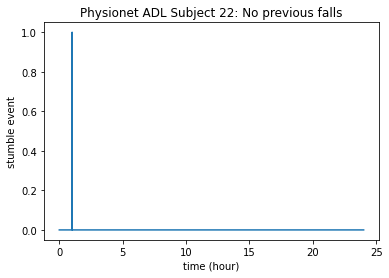

In [192]:
resultt2 = np.column_stack((t, result2))
t = np.arange(0,len(result),1) / t_factor
plt.plot(resultt2[:,0][10:],(resultt2[:,2][10:]>0.6))
plt.title("Physionet ADL Subject 22: No previous falls")
plt.ylabel("stumble event")
plt.xlabel("time (hour)")

0 CO001


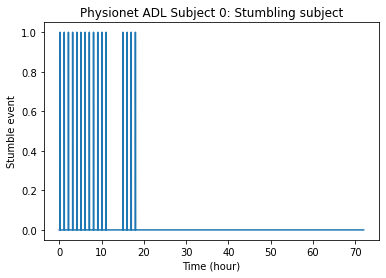

1 CO002


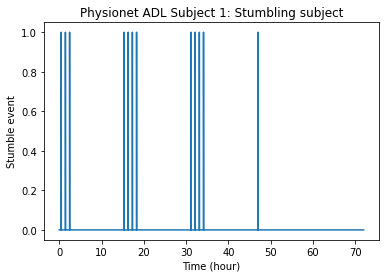

2 CO003


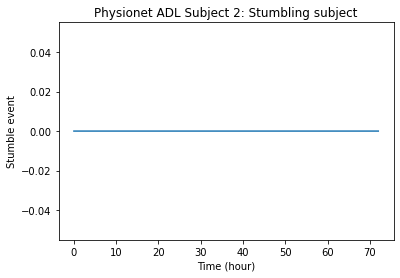

3 CO004


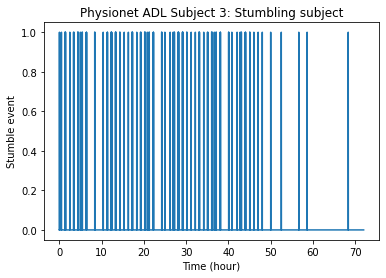

4 CO005


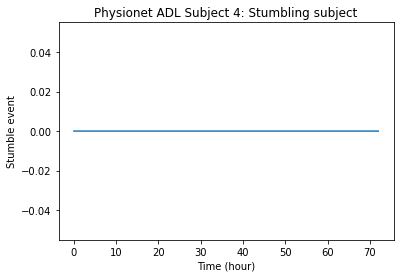

5 CO006


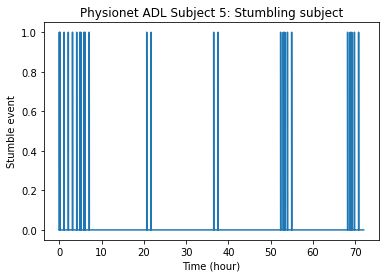

6 CO007


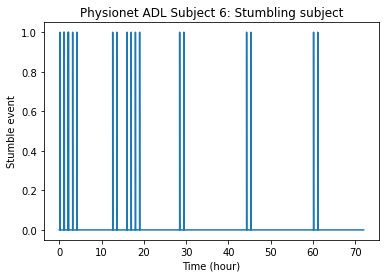

7 CO008


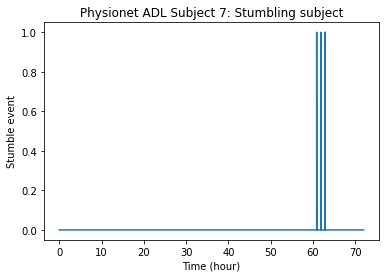

8 CO009


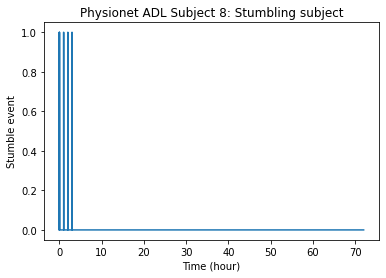

9 CO010


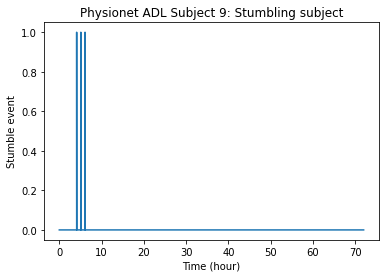

10 CO011


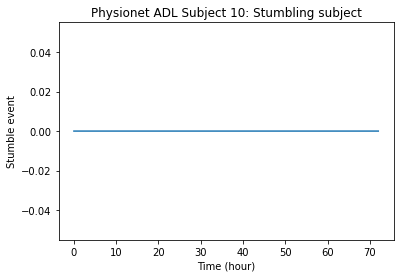

11 CO012


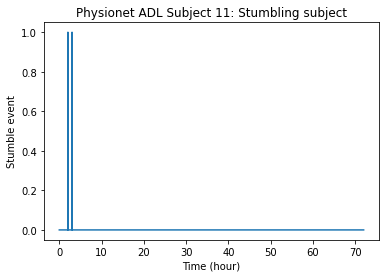

12 CO013


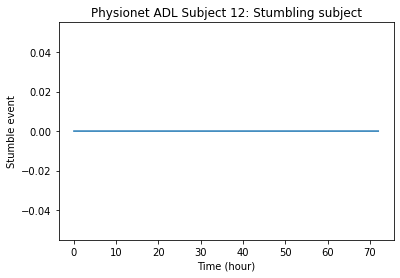

13 CO014


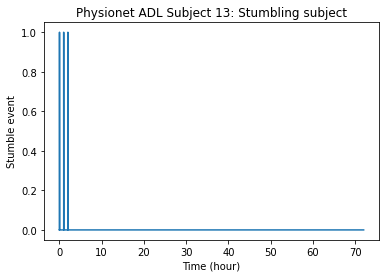

14 CO015


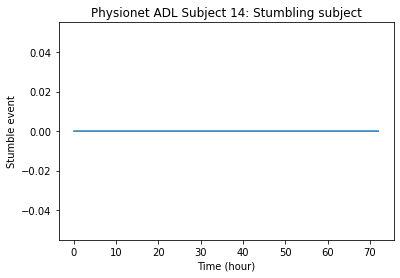

15 CO016


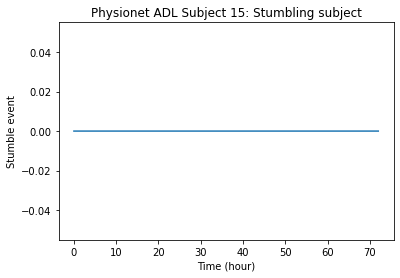

16 CO017


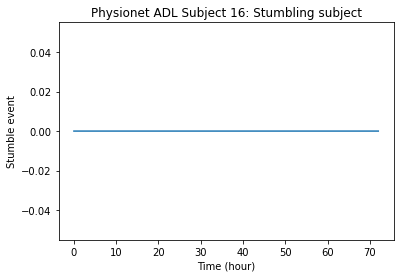

17 CO018


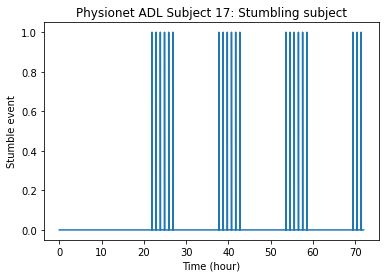

18 CO019


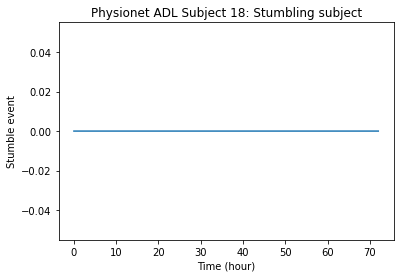

19 CO020


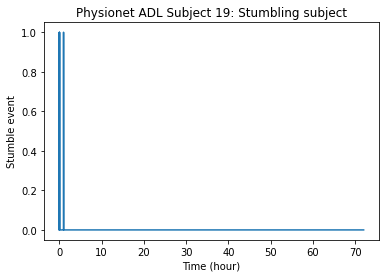

20 CO021


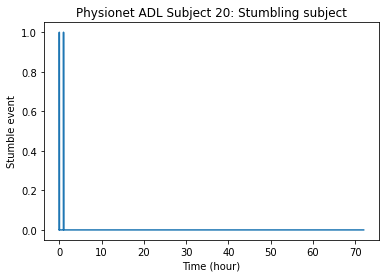

21 CO022


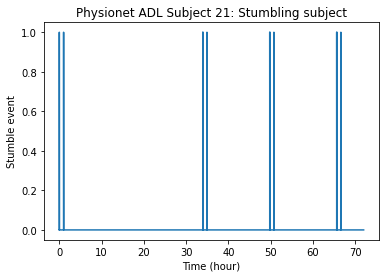

22 CO023


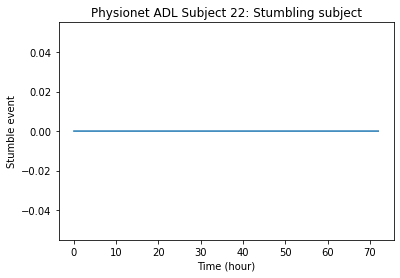

23 CO024


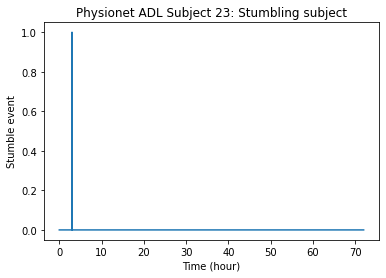

24 CO025


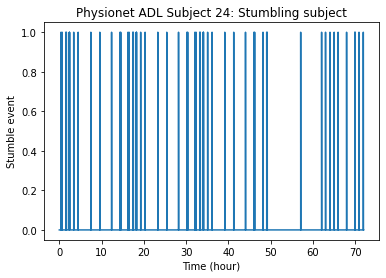

25 CO027


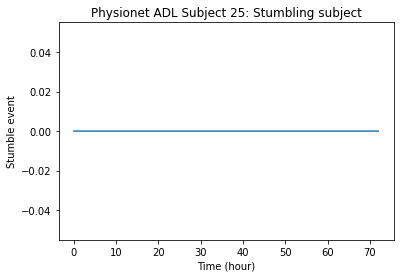

26 CO028


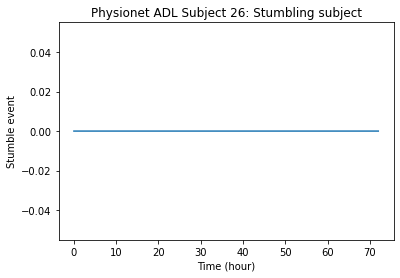

27 CO029


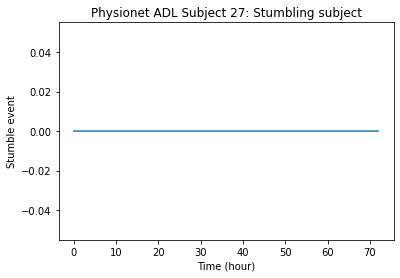

28 CO030


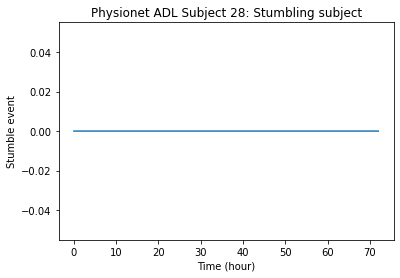

29 CO031


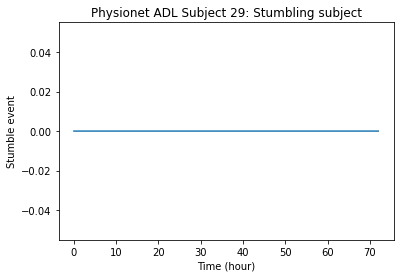

30 CO032


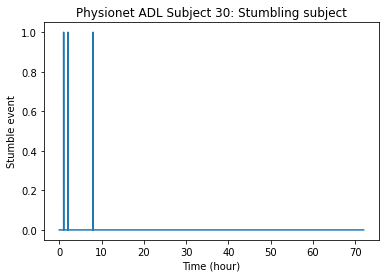

31 CO035


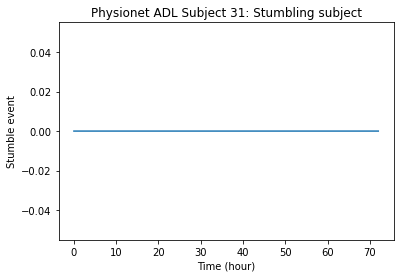

32 CO036


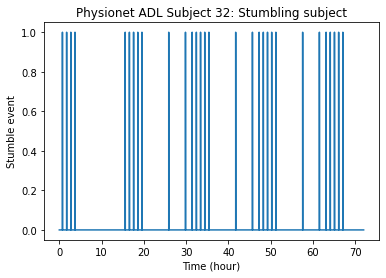

33 CO037


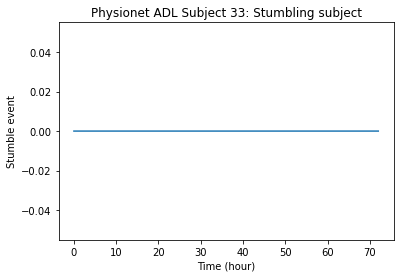

34 CO038


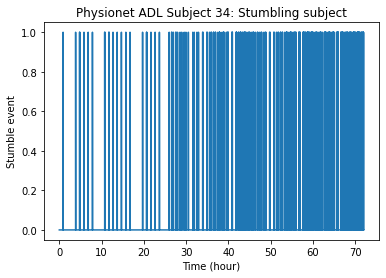

35 CO039


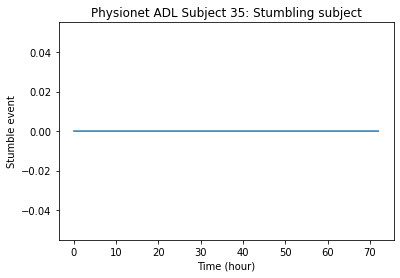

36 CO040


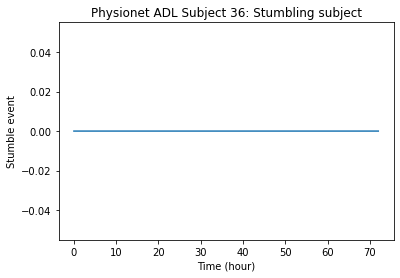

37 CO041


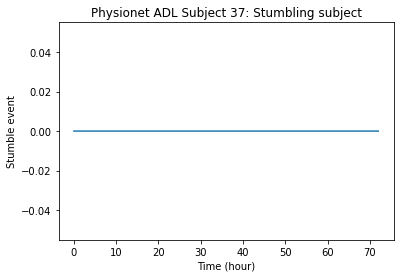

38 CO042


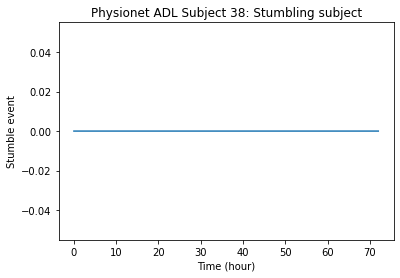

39 CO044


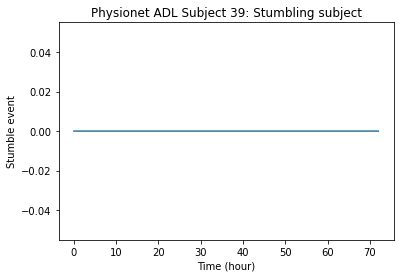

40 FL001


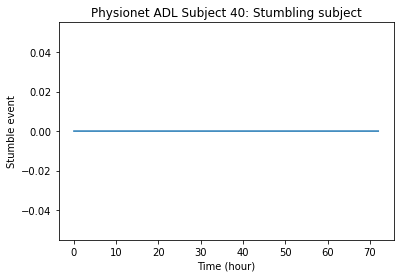

41 FL004


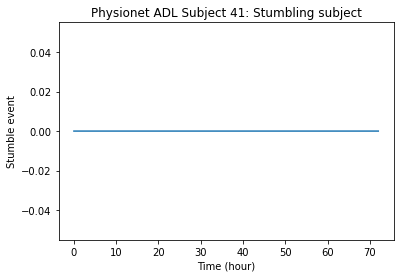

42 FL005


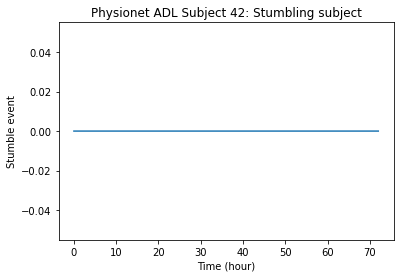

43 FL006


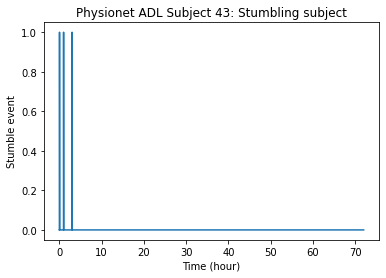

44 FL007


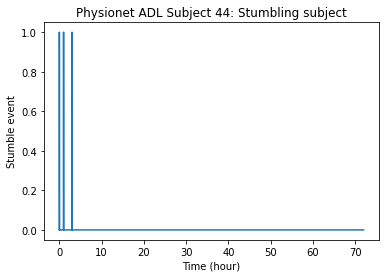

45 FL008


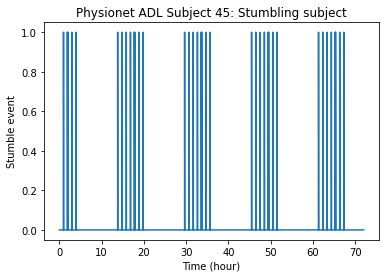

46 FL009


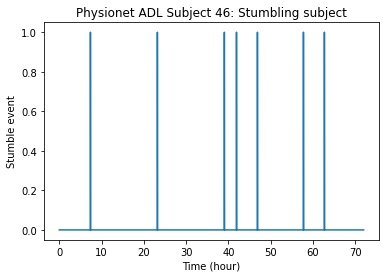

47 FL010


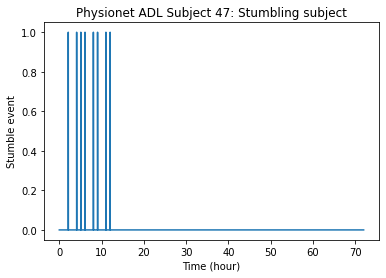

48 FL011


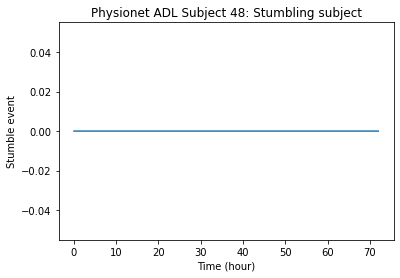

49 FL014


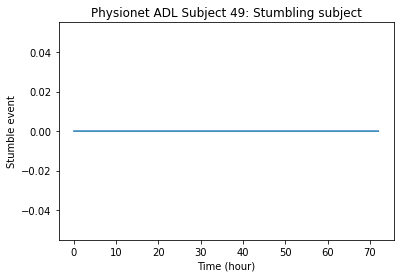

50 FL015


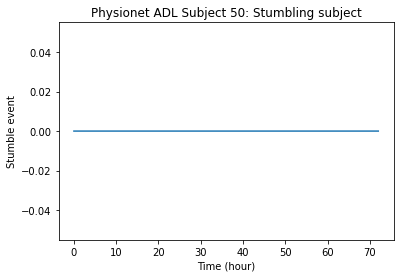

51 FL016


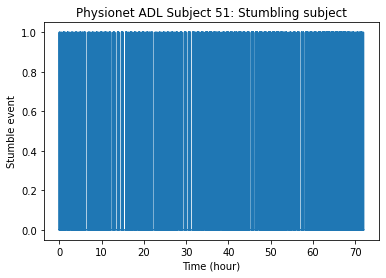

52 FL018


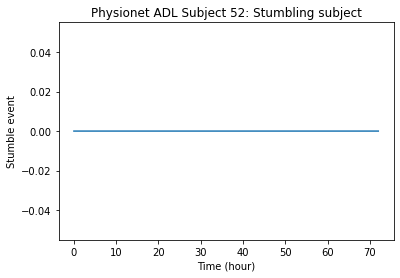

53 FL019


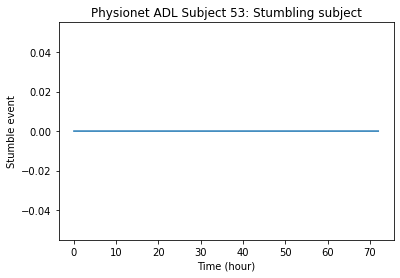

54 FL020


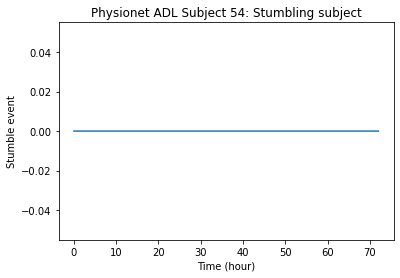

55 FL021


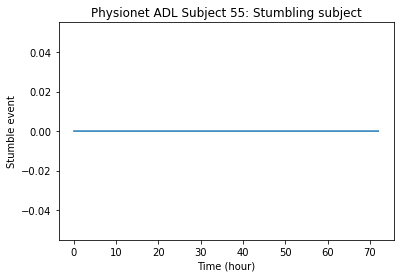

56 FL022


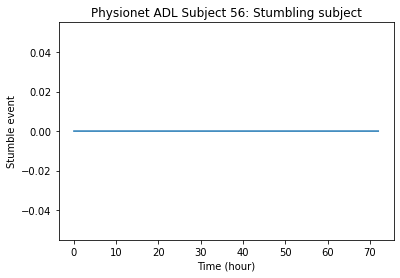

57 FL023


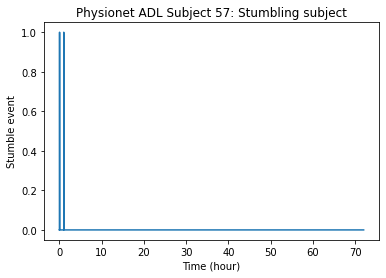

58 FL024


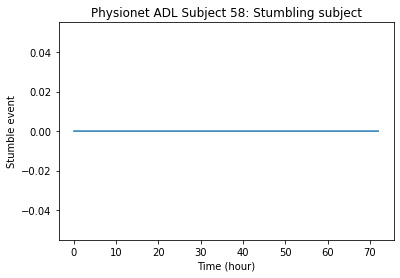

59 FL025


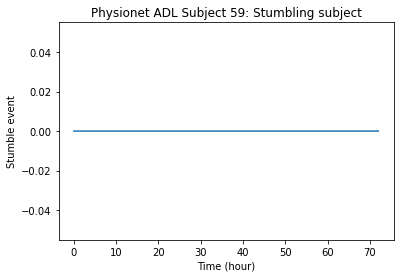

60 FL026


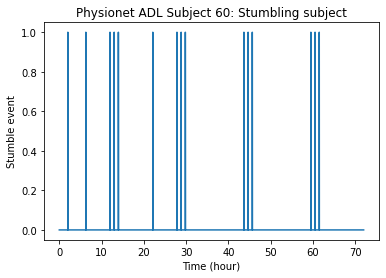

61 FL027


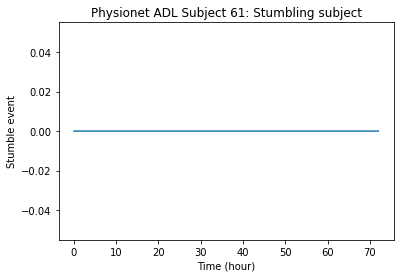

62 FL028


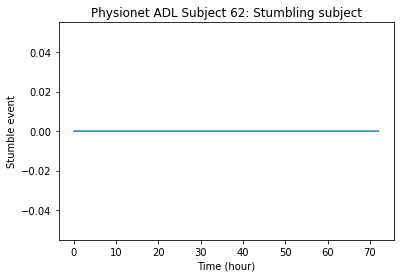

63 FL029


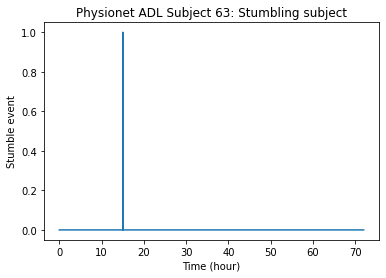

64 FL030


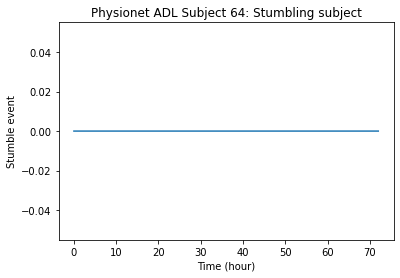

65 FL031


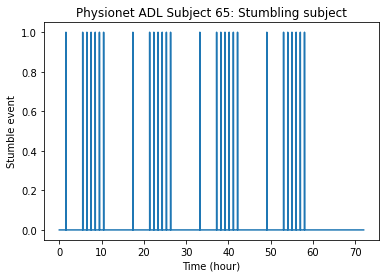

66 FL032


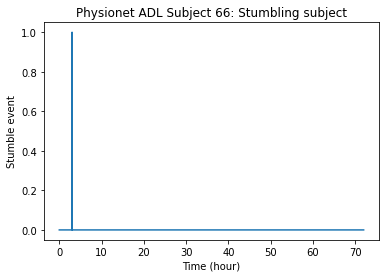

67 FL033


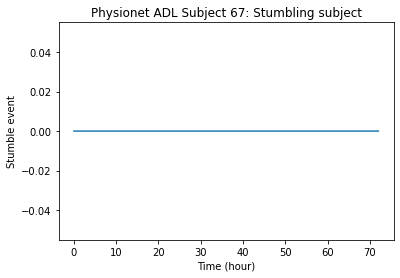

68 FL034


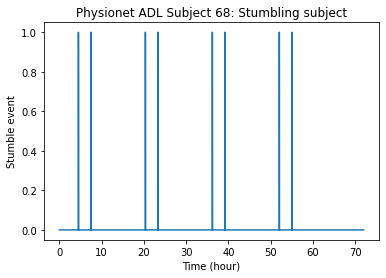

69 FL035


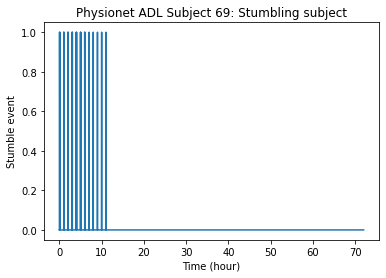

70 FL036


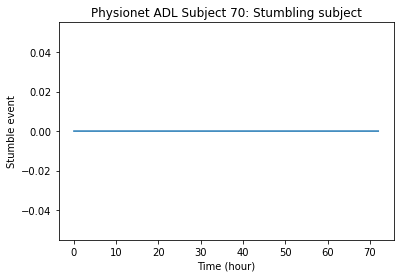

71 LabWalks/co001_base


ValueError: sampfrom must be shorter than the signal length

In [20]:
alpha_ss = 0.6
results = {}
for irec in range(len(dbs)):
# for irec in [21,31,41,51,61]:
    print(irec, dbs[irec])
    _result = grab_hours(dbs, irec=irec, hour_start=0, hour_end=72)
    t = np.arange(0,len(_result),1) / t_factor
    results[irec] = np.column_stack((t,_result))
    plt.plot(results[irec][:,0],results[irec][:,2] > alpha_ss)
    plt.title("Physionet ADL Subject %i: Stumbling subject" % irec)
    plt.ylabel("Stumble event")
    plt.xlabel("Time (hour)")
    plt.show()

In [2]:
import pickle

def save_results(d, fname = "physionet_results.pik"):
    with open(fname, 'wb') as handle:
        pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

def load_results(fname = "physionet_results.pik"):
    with open(fname, 'rb') as handle:
        d = pickle.load(handle)
    return d


In [27]:
save_results(results)

In [3]:
results = load_results()

1 CO002


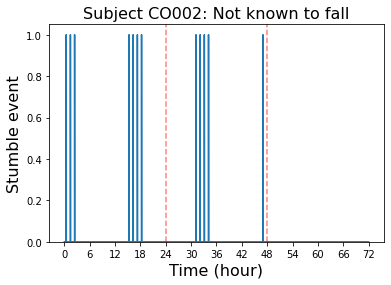

21 CO022


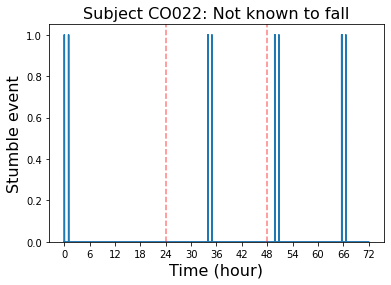

31 CO035


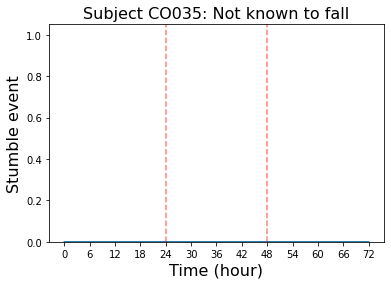

41 FL004


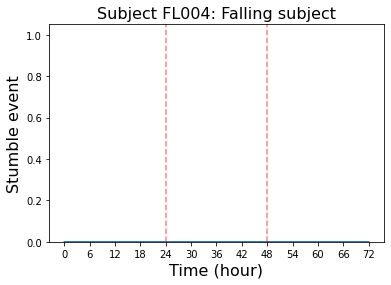

51 FL016


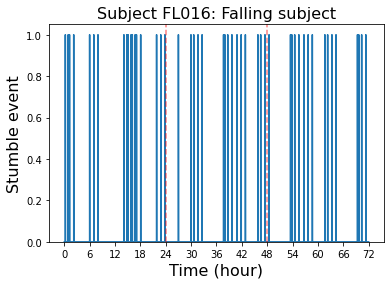

61 FL027


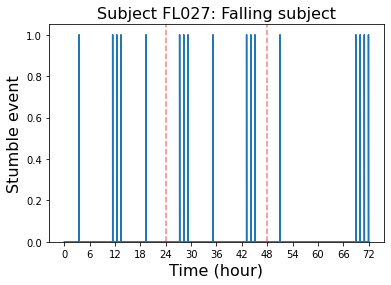

In [216]:
sub_thresh = {1: 0.6,21: 0.6,31: 0.55,41: 0.6, 51: 0.8, 61: 0.5}
sub_type = {'C': "Not known to fall", 'F': "Falling subject"}
for irec in [1,21,31,41,51,61]:
# for irec in [21,31,41,51,61]:
    print(irec, dbs[irec])
    plt.plot(results[irec][:,0],results[irec][:,2] > sub_thresh[irec])
    plt.xticks(np.arange(0,73,6))
    plt.ylim([0,1.05])
    plt.axvline(24,0,1, ls='--', c='r', alpha=0.5)
    plt.axvline(48,0,1, ls='--', c='r', alpha=0.5)
    plt.title("Subject %s: %s" % (dbs[irec], sub_type[dbs[irec][0]]), fontsize="16")
    plt.ylabel("Stumble event", fontsize="16")
    plt.xlabel("Time (hour)", fontsize="16")
    plt.show()

## So now what about calculating risk?
To decide on a clear way of calculating risk, I will now test out different thresholds for stumbles and falls identified in in the 3-day dataset for each individual.

To do this, I will calculate the Absolute Risk $\text{AR}$ based on the number of events in the group known to fall compared to the group not known to fall, and this will allow me to choose a baseline for the amount of risk associated with a given fall at a given threshold.
\begin{equation}
\text{AR} = \frac{\Sigma_\text{i}N_i^\text{stumble}}{N_\text{group}}
\end{equation}

where $N_i^\text{stumble}$ is the total stumbles of each individual each day, and $N_\text{group}$ is the total number in the fallers or non-fallers. Using this information, I will now calculate the risk associated with each stumble and collect those for an array of thresholds.

In [10]:
import numpy as np
dbs_cat = []
for dbn in dbs:
    dbs_cat.append(dbn[0])
dbs_cat = np.array(dbs_cat)

dbs = np.array(dbs)
dbs_cat = []
for dbn in dbs:
    dbs_cat.append(dbn[0])
dbs_cat = np.array(dbs_cat)
t, n = np.unique(dbs_cat, return_counts=True)
print(t, n)   

ts, ns = np.unique(dbs_cat, return_counts=True)
for i in range(len(ts)):
    print(t[i], 'has', n[i], 'cases')

['C' 'F' 'L'] [40 31 73]
C has 40 cases
F has 31 cases
L has 73 cases


But here we are not interested in the L's as they seem extraneous in the dataset. From the database, I know only about the C and F cases, where C corresponds with non-fallers and F corresponds with fallers.

In [11]:
thresholds = np.arange(0.25,1,0.05)
N_stumble = {}
N_fall = {}

def N_key(s,t):
    return s,"%4.2f"%t

for thresh in thresholds:
    for i in range(n[0]+n[1]):
        N_stumble[N_key(dbs[i],thresh)] = results[i][:,2] > thresh
        N_fall[N_key(dbs[i],thresh)] = results[i][:,3] > thresh

And now I will gather these all into a dictionary

In [13]:
NS = {}
for thresh in thresholds:
    N_nf_s = []
    N_nf_f = []
    for i in range(0,n[0]):
        _N_s = len(N_stumble[N_key(dbs[i],thresh)][N_stumble[N_key(dbs[i],thresh)]])
        _N_f = len(N_fall[N_key(dbs[i],thresh)][N_fall[N_key(dbs[i],thresh)]])
        N_nf_s.append(_N_s)
        N_nf_f.append(_N_f)
    NS[N_key('CS',thresh)] = np.array(N_nf_s)
    NS[N_key('CF',thresh)] = np.array(N_nf_f)
        
    N_yf_s = []
    N_yf_f = []
    for i in range(n[0],n[0]+n[1]):
        _N_s = len(N_stumble[N_key(dbs[i],thresh)][N_stumble[N_key(dbs[i],thresh)]])
        _N_f = len(N_fall[N_key(dbs[i],thresh)][N_fall[N_key(dbs[i],thresh)]])
        N_yf_s.append(_N_s)
        N_yf_f.append(_N_f)
        
    NS[N_key('FS',thresh)] = np.array(N_yf_s)
    NS[N_key('FF',thresh)] = np.array(N_yf_f)

So that I can make some histograms of the number of falls for a given case.

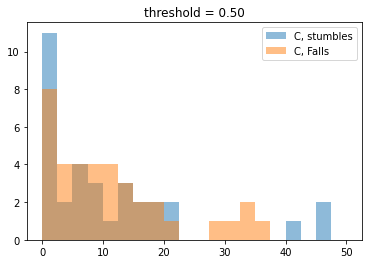

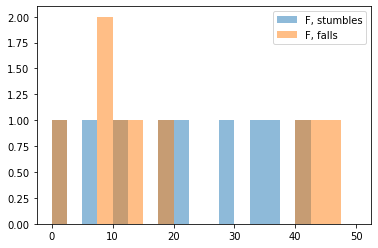

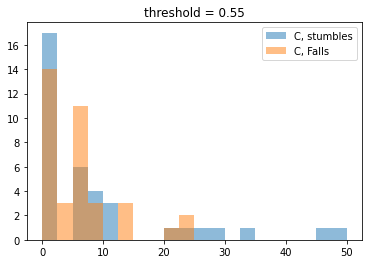

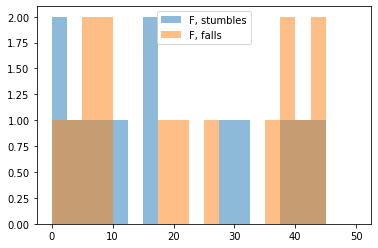

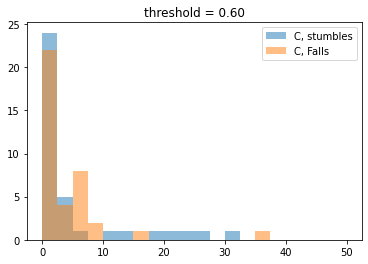

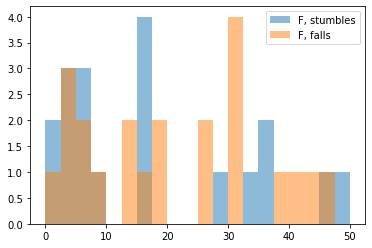

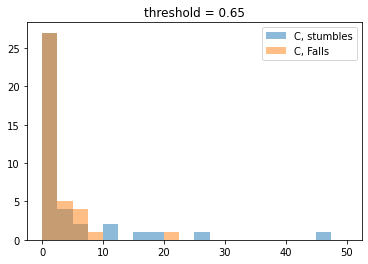

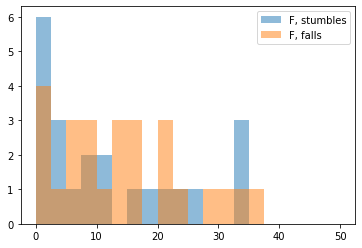

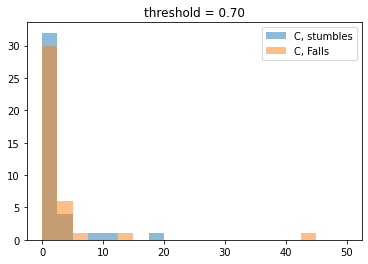

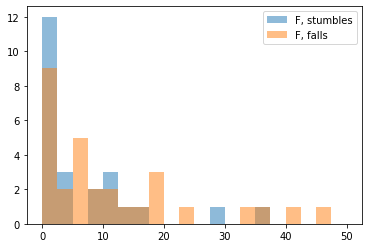

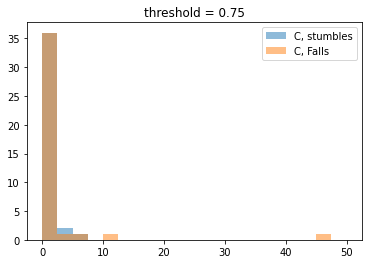

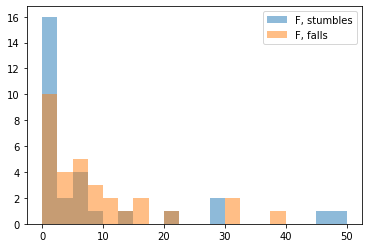

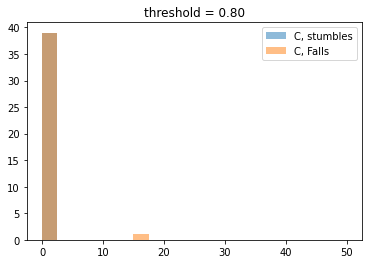

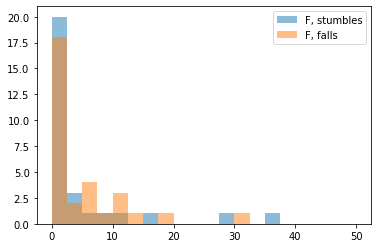

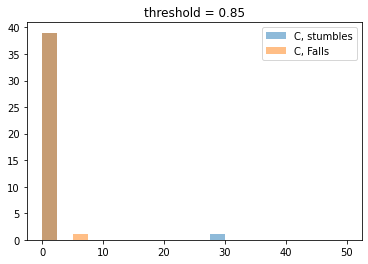

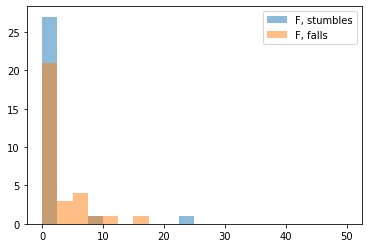

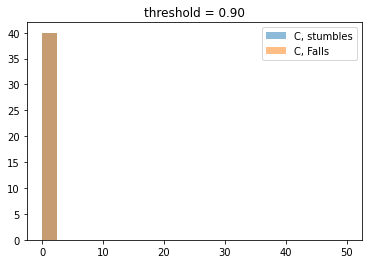

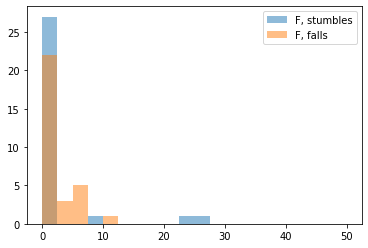

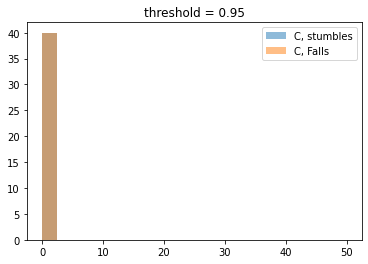

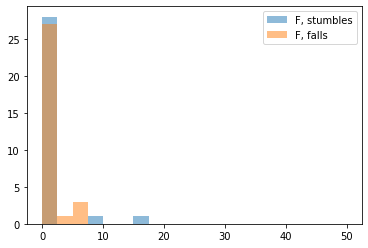

In [15]:
import matplotlib.pyplot as plt

n_range = [0,50]
n_bins = 20
margin = 0.2
for thresh in thresholds:
    if thresh > thresholds[0] + margin:
        plt.title("threshold = %4.2f" % thresh)
        plt.hist(NS[N_key('CS',thresh)], range=n_range, bins=n_bins, alpha=0.5, label='C, stumbles')
        plt.hist(NS[N_key('CF',thresh)], range=n_range, bins=n_bins, alpha=0.5, label='C, Falls')
        plt.legend()
        plt.show()

        plt.hist(NS[N_key('FS',thresh-margin)], range=n_range, bins=n_bins, alpha=0.5, label='F, stumbles')
        plt.hist(NS[N_key('FF',thresh-margin)], range=n_range, bins=n_bins, alpha=0.5, label='F, falls')
        plt.legend()
        plt.show()

So while this is not the best outcome, since I cannot distinguish the known fallers and the non-fallers, I am choosing an ad-hoc solution for the sake of completing my product. Knowing that the fallers have a history of falls, I will give them a different "baseline" for considering their risk. As a result, I will evaluate the risk of falling using the following risk metric. For those with a previous fall, they are given a higher threshold.

In [16]:
ARC = np.mean(NS[N_key('CS',0.75)])
ARF = np.mean(NS[N_key('FS',0.75-margin)])
RR = ARC / ARF
print("Absolute Risk of Control", ARC)
print("Absolute Risk of Fallers", ARF)
print("Relative Risk of Fallers", RR)

Absolute Risk of Control 3.95
Absolute Risk of Fallers 67.96774193548387
Relative Risk of Fallers 0.05811580446131941


So based on this calculation, I will assume that I can reduce the risk of falling to as much as 8% if I were actually able to identify these falls correctly. If you've read this far, maybe you've found the main hole in this project. I will leave it as an easter egg for those who are interested.

In [22]:
ARC = np.mean(NS[N_key('CS',0.75)])
ARF = np.mean(NS[N_key('FS',0.75)])
RR = ARC / ARF
print("Absolute Risk of Control", ARC)
print("Absolute Risk of Fallers", ARF)
print("Relative Risk of Fallers", RR)

Absolute Risk of Control 3.95
Absolute Risk of Fallers 6.451612903225806
Relative Risk of Fallers 0.6122500000000001


So in principle I could reduce the risk of falling folks by about half.

In [25]:
results[0][:,0]

array([0.00000000e+00, 7.11237553e-04, 1.42247511e-03, ...,
       7.19978663e+01, 7.19985775e+01, 7.19992888e+01])